# Setup

In [1]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.7 MB/s eta 0:00:00


In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [2]:
image_path = '/kaggle/input/house-price-multimodal-dataset/images'
tabular_path = '/kaggle/input/house-price-multimodal-dataset/full_dataset.csv'

label = 'Price'

random_state = 13

# Dataset

In [3]:
df = pd.read_csv(tabular_path)
df.drop(columns=['Tipe Iklan', 'Tipe Properti'], inplace=True)

# EDA

# Data Processing

In [33]:
# def price_categories(price):
#     Q1 = df[label].quantile(0.25)
#     Q3 = df[label].quantile(0.75)

#     if(price <= Q1):
#         return 'lower'
#     elif((Q1 < price) & (price < Q3)):
#         return 'medium'
#     elif(price >= Q3):
#         return 'high'

# df['price_categories'] = df[label].apply(price_categories)

In [7]:
# Compute Q1, Q3, and IQR
Q1 = df[label].quantile(0.25)
Q3 = df[label].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[label] < lower_bound) | (df[label] > upper_bound)]
df = df[(df[label] >= lower_bound) & (df[label] <= upper_bound)]

<Axes: xlabel='Price'>

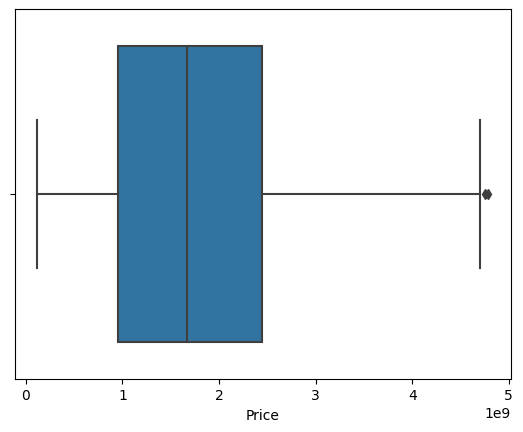

In [8]:
sns.boxplot(df, x=label)

In [9]:
# Handling Missing values
df.loc[df['Luas Bangunan'].isna(), 'Luas Bangunan'] = df['Luas Bangunan'].median()
df.loc[df['Luas Tanah'].isna(), 'Luas Tanah'] = df['Luas Tanah'].median()
df.loc[df['Daya Listrik'].isna(), 'Daya Listrik'] = df['Daya Listrik'].median()
df.loc[df['Tahun Dibangun'].isna(), 'Tahun Dibangun'] = df['Tahun Dibangun'].median()

df.loc[df['Kamar Tidur'].isna(), 'Kamar Tidur'] = df['Kamar Tidur'].mode()[0]
df.loc[df['Kamar Mandi'].isna(), 'Kamar Mandi'] = df['Kamar Mandi'].mode()[0]
df.loc[df['Carpots'].isna(), 'Carpots'] = df['Carpots'].mode()[0]
df.loc[df['Garasi'].isna(), 'Garasi'] = df['Garasi'].mode()[0]
df.loc[df['Sertifikat'].isna(), 'Sertifikat'] = df['Sertifikat'].mode()[0]
df.loc[df['Jumlah Lantai'].isna(), 'Jumlah Lantai'] = df['Jumlah Lantai'].mode()[0]

df.loc[df['Interior'].isna(), 'Interior'] = "Unknown"
df.loc[df['Orientasi Bangunan'].isna(), 'Orientasi Bangunan'] = "Unknown"
df.loc[df['Nama Perumahan'].isna(), 'Nama Perumahan'] = "Unknown"

df['District'] = df.groupby('City')['District'].transform(lambda x: x.fillna(x.mode()[0]))
df["Latitude"] = df.groupby("City")["Latitude"].transform(lambda x: x.fillna(x.mean()))
df["Longitude"] = df.groupby("City")["Longitude"].transform(lambda x: x.fillna(x.mean()))

df.loc[df['Orientasi Bangunan'] == '3', 'Orientasi Bangunan'] = 'Unknown'
df.loc[df['Orientasi Bangunan'] == '1', 'Orientasi Bangunan'] = 'Unknown'
df.loc[df['Orientasi Bangunan'] == '4', 'Orientasi Bangunan'] = 'Unknown'
df.loc[df['Orientasi Bangunan'] == '2', 'Orientasi Bangunan'] = 'Unknown'

LE = LabelEncoder()

df['Sertifikat'] = LE.fit_transform(df['Sertifikat'])
df['Interior'] = LE.fit_transform(df['Interior'])
df['Orientasi Bangunan'] = LE.fit_transform(df['Orientasi Bangunan'])
df['Province'] = LE.fit_transform(df['Province'])
df['City'] = LE.fit_transform(df['City'])
df['District'] = LE.fit_transform(df['District'])
df['Nama Perumahan'] = LE.fit_transform(df['Nama Perumahan'])

# Modeling

In [7]:
price_map = {
    'lower' : 0,
    'medium' : 1,
    'high' : 2
}

df['price_categories'] = df['price_categories'].map(price_map)

## Tabular Regression

In [ ]:
X = df.drop(columns=['ID', label, 'Title', 'Address', 'Province', 'images_path'])
y = df[label] / 1000000

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [48]:
def rmse(y_pred, y_actual):
    return np.sqrt(mean_squared_error(y_actual, y_pred))

reg_models = {
    'Linear Regression' : LinearRegression(),
    'Lasso Regression' : Lasso(),
    'Ridge Regression' : Ridge(),
    'Extra Tress Regression' : ExtraTreesRegressor(random_state=13),
    'Random Forest Regression' : RandomForestRegressor(random_state=13),
    'Gradient Boosting Regression' : GradientBoostingRegressor(random_state=13),
    'XGBoost' : XGBRegressor(random_state=13),
    'LightGBM' : LGBMRegressor(random_state=13),
    'Catboost' : CatBoostRegressor(verbose=0, random_state=13),
}

for name, model in reg_models.items():
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_val)
    # score = rmse(y_pred, y_val)

    score = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    score = np.mean(score)
    print(f'{name} : RMSE {-1 * score} Juta')

Linear Regression : RMSE 16921327236.830439 Juta
Lasso Regression : RMSE 16317410378.66344 Juta
Ridge Regression : RMSE 16556889558.569717 Juta


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.19526e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.39936e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.4178e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.40266e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Extra Tress Regression : RMSE 398.50028264154787 Juta
Random Forest Regression : RMSE 391.6694454861964 Juta
Gradient Boosting Regression : RMSE 395.68148958713846 Juta
XGBoost : RMSE 421.3542128183279 Juta
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Number of data points in the train set: 1272, number of used features: 18
[LightGBM] [Info] Start training from score 1670.058922
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


## Tabular Classification

In [72]:
X = df.drop(columns=['ID', label, 'Title', 'Address', 'images_path', 'price_categories'])
y = df['price_categories']

In [73]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
classes = np.unique(y)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))

cat_models = {
    'Logistic Regression' : LogisticRegression(class_weight='balanced'),
    'SVM' : SVC(class_weight='balanced'),
    'Extra Trees Classifier' : ExtraTreesClassifier(class_weight='balanced', random_state=13),
    'Random Forest Classifier' : RandomForestClassifier(class_weight='balanced', random_state=13),
    'Gradient Boosting Classifier' : GradientBoostingClassifier(random_state=13),  # No direct class_weight support
    'XGBoost' : XGBClassifier(scale_pos_weight=class_weights[1], random_state=13),  # Only for binary classification
    'LightGBM' : LGBMClassifier(class_weight='balanced', random_state=13),
    'Catboost' : CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=13),
}

for name, model in cat_models.items():
    score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'{name} : {np.mean(score)} % acc')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr

Logistic Regression : 0.4534726731601732 % acc
SVM : 0.3521956168831169 % acc
Extra Trees Classifier : 0.4336580086580086 % acc
Random Forest Classifier : 0.5459307359307359 % acc
Gradient Boosting Classifier : 0.5724242424242424 % acc


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weigh

XGBoost : 0.5656980519480519 % acc
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 1538, number of used features: 17
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data 

## Image Classification 

In [12]:
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor

class CustomDataset(Dataset):
    def __init__(self, images_path, labels, root_dir, feature_extractor, transform=None):
        self.images_path = images_path.tolist()
        self.labels = labels.tolist()
        self.root_dir = root_dir
        self.transform = transform
        self.feature_extractor = feature_extractor
        self.label_map = {
            'lower' : 0,
            'medium' : 1,
            'high' : 2
        }

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.images_path[index])
        image = Image.open(image_path).convert('RGB')

        label_str = self.labels[index]
        label = self.label_map[label_str]

        encoding = self.feature_extractor(images=image, return_tensors="pt")
        encoding = {key: value.squeeze(0) for key, value in encoding.items()}  # Remove batch dim
        encoding['labels'] = torch.tensor(label, dtype=torch.long)

        return encoding


# Load Hugging Face ViT model and feature extractor
model_name = 'google/vit-large-patch16-224-in21k' 
model = ViTForImageClassification.from_pretrained(model_name, num_labels=3)

# Define the feature extractor 
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

kaggle_path = '/kaggle/input/house-price-multimodal-dataset'

X = df['images_path']
y = df['price_categories']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

train_dataset = CustomDataset(X_train, y_train, kaggle_path, feature_extractor)
val_dataset = CustomDataset(X_val, y_val, kaggle_path, feature_extractor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
        
        for batch in loop:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader):
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                outputs = model(**inputs)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

                preds = outputs.logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    
        avg_val_loss = val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)
        val_acc = correct / total

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


    return model, train_loss_history, val_loss_history

model, train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, optimizer, criterion)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Epoch 1/10:  16%|█▋        | 8/49 [00:23<01:54,  2.79s/it, loss=0.982]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


Epoch 1/10 | Train Loss: 0.9197 | Val Loss: 0.7483 | Val Acc: 0.6234


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


Epoch 2/10 | Train Loss: 0.4362 | Val Loss: 0.6995 | Val Acc: 0.6597


100%|██████████| 13/13 [00:11<00:00,  1.12it/s]


Epoch 3/10 | Train Loss: 0.1373 | Val Loss: 0.7628 | Val Acc: 0.6649


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


Epoch 4/10 | Train Loss: 0.0514 | Val Loss: 0.8828 | Val Acc: 0.6675


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 5/10 | Train Loss: 0.0178 | Val Loss: 0.9900 | Val Acc: 0.6831


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 6/10 | Train Loss: 0.0076 | Val Loss: 1.0571 | Val Acc: 0.6987


100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Epoch 7/10 | Train Loss: 0.0048 | Val Loss: 1.0833 | Val Acc: 0.6935


100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


Epoch 8/10 | Train Loss: 0.0035 | Val Loss: 1.1504 | Val Acc: 0.6909


100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


Epoch 9/10 | Train Loss: 0.0028 | Val Loss: 1.1698 | Val Acc: 0.6935


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]

Epoch 10/10 | Train Loss: 0.0024 | Val Loss: 1.2082 | Val Acc: 0.6909


In [13]:
model, train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, optimizer, criterion)

100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 1/10 | Train Loss: 0.0025 | Val Loss: 1.2591 | Val Acc: 0.7013


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


Epoch 2/10 | Train Loss: 0.0020 | Val Loss: 1.2714 | Val Acc: 0.6935


100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


Epoch 3/10 | Train Loss: 0.0021 | Val Loss: 1.2969 | Val Acc: 0.6935


100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


Epoch 4/10 | Train Loss: 0.0019 | Val Loss: 1.3094 | Val Acc: 0.6935


100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


Epoch 5/10 | Train Loss: 0.0021 | Val Loss: 1.3499 | Val Acc: 0.7117


100%|██████████| 13/13 [00:11<00:00,  1.12it/s]


Epoch 6/10 | Train Loss: 0.0017 | Val Loss: 1.3510 | Val Acc: 0.6987


100%|██████████| 13/13 [00:11<00:00,  1.12it/s]


Epoch 7/10 | Train Loss: 0.0017 | Val Loss: 1.3640 | Val Acc: 0.6961


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


Epoch 8/10 | Train Loss: 0.0017 | Val Loss: 1.3889 | Val Acc: 0.6935


100%|██████████| 13/13 [00:11<00:00,  1.12it/s]


Epoch 9/10 | Train Loss: 0.0015 | Val Loss: 1.3954 | Val Acc: 0.6961


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]

Epoch 10/10 | Train Loss: 0.0016 | Val Loss: 1.4388 | Val Acc: 0.7091


In [14]:
np.mean([
    0.6234,
    0.6597,
    0.6649,
    0.6675,
    0.6831,
    0.6987,
    0.6935,
    0.6909,
    0.6935,
    0.6909,
    0.7013,
    0.6935,
    0.6935,
    0.6935,
    0.7117,
    0.6987,
    0.6961,
    0.6935,
    0.6961,
    0.7091
])

0.6876549999999999

## Text Modeling

In [ ]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Initialize Sastrawi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def text_processing(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)

    indonesian_stopwords = set(stopwords.words('indonesian'))
    tokens = [word for word in tokens if word not in indonesian_stopwords]

    tokens = [stemmer.stem(word) for word in tokens]
    text = ' '.join(tokens)

    return text

X_train_text_processed = X_train_text.apply(text_processing)
X_val_text_processed = X_val_text.apply(text_processing)

# =====================================================================================================

from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large').to(device)

def get_e5_embeddings(texts, batch_size=32):
    """Compute E5 embeddings with proper normalization and batching."""
    embeddings = []
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch = texts[i:i + batch_size]
            
            # Tokenize with E5's specific format (add prefix)
            batch = ["query: " + text for text in batch]  # or "passage: " depending on use case
            
            inputs = tokenizer(
                batch,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512,  # E5 can handle longer sequences
            ).to(device)
            
            outputs = model(**inputs)
            
            # E5 recommends using last_hidden_state[:, 0] (CLS token) instead of mean pooling
            batch_embeddings = outputs.last_hidden_state[:, 0].cpu().numpy()
            
            # Normalize embeddings (important for E5)
            batch_embeddings = batch_embeddings / np.linalg.norm(batch_embeddings, axis=1, keepdims=True)
            
            embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

# Compute embeddings
X_e5_train = get_e5_embeddings(X_train_text.tolist())
X_e5_val = get_e5_embeddings(X_val_text.tolist())

# Create a DataFrame where each column is a BERT dimension
e5_columns = [f"e5{i}" for i in range(X_e5_train.shape[1])]
e5_df_train = pd.DataFrame(X_e5_train, columns=e5_columns)
e5_df_val = pd.DataFrame(X_e5_val, columns=e5_columns)

## Ealy Fusion 

In [12]:
price_map = {
    'lower' : 0,
    'medium' : 1,
    'high' : 2
}

# df['price_categories'] = df['price_categories'].map(price_map)

X = df.drop(columns=['ID', label,'Address', 'Province'])
y = df[label] / 1000000

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

X_train_tab = X_train.drop(columns=['images_path', 'Title'])
X_val_tab = X_val.drop(columns=['images_path', 'Title'])

X_train_img = X_train['images_path']
X_val_img = X_val['images_path']

X_train_text = X_train['Title']
X_val_text = X_val['Title']

In [13]:
from tqdm import tqdm
import torch
from transformers import AutoImageProcessor, ResNetModel, AutoModel
from PIL import Image
from sklearn.decomposition import PCA

# Load model
model_name = "facebook/dinov2-large"  
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def extract_image_embeddings(image_paths):
    kaggle_path = '/kaggle/input/house-price-multimodal-dataset'

    embeddings = []

    for path in tqdm(image_paths):
        image_path = os.path.join(kaggle_path, path)
        image = Image.open(image_path).convert('RGB')
        inputs = image_processor(image, return_tensors="pt")

        # Move the input to the device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # embedding = outputs.pooler_output.squeeze(-1).squeeze(-1).cpu().numpy() #Resnet50
            embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy() #ViT 

        # embeddings.append(embedding) #Resnet50
        embeddings.append(embedding.squeeze(0)) #ViT

    return np.vstack(embeddings)

img_train_embeddings = extract_image_embeddings(X_train_img)
img_val_embeddings = extract_image_embeddings(X_val_img)

train_columns = [f'img_emb_{i}' for i in range(img_train_embeddings.shape[1])]
val_columns = [f'img_emb_{i}' for i in range(img_val_embeddings.shape[1])]

train_image_df = pd.DataFrame(img_train_embeddings, columns=train_columns)
val_image_df = pd.DataFrame(img_val_embeddings, columns=val_columns)

# Apply PCA to reduce to 3 components
# pca = PCA(n_components=3)
# train_image_pca = pca.fit_transform(img_train_embeddings)
# val_image_pca = pca.transform(img_val_embeddings)

# # Convert to DataFrames with meaningful column names
# train_image_df = pd.DataFrame(train_image_pca, 
#                              columns=['img_pc1', 'img_pc2', 'img_pc3'])
# val_image_df = pd.DataFrame(val_image_pca, 
#                            columns=['img_pc1', 'img_pc2', 'img_pc3'])

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

 13%|█▎        | 163/1272 [00:13<01:29, 12.38it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 319/319 [00:24<00:00, 13.12it/s]


In [14]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Initialize Sastrawi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def text_processing(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)

    indonesian_stopwords = set(stopwords.words('indonesian'))
    tokens = [word for word in tokens if word not in indonesian_stopwords]

    tokens = [stemmer.stem(word) for word in tokens]
    text = ' '.join(tokens)

    return text

X_train_text_processed = X_train_text.apply(text_processing)
X_val_text_processed = X_val_text.apply(text_processing)

# =====================================================================================================

from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large').to(device)
model.to(device)

def get_e5_embeddings(texts, batch_size=32):
    """Compute E5 embeddings with proper normalization and batching."""
    embeddings = []
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch = texts[i:i + batch_size]
            
            # Tokenize with E5's specific format (add prefix)
            batch = ["query: " + text for text in batch]  # or "passage: " depending on use case
            
            inputs = tokenizer(
                batch,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512,  # E5 can handle longer sequences
            ).to(device)
            
            outputs = model(**inputs)
            
            # E5 recommends using last_hidden_state[:, 0] (CLS token) instead of mean pooling
            batch_embeddings = outputs.last_hidden_state[:, 0].cpu().numpy()
            
            # Normalize embeddings (important for E5)
            batch_embeddings = batch_embeddings / np.linalg.norm(batch_embeddings, axis=1, keepdims=True)
            
            embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

# Compute embeddings
X_e5_train = get_e5_embeddings(X_train_text.tolist())
X_e5_val = get_e5_embeddings(X_val_text.tolist())

# Create a DataFrame where each column is a BERT dimension
e5_columns = [f"e5{i}" for i in range(X_e5_train.shape[1])]
e5_df_train = pd.DataFrame(X_e5_train, columns=e5_columns)
e5_df_val = pd.DataFrame(X_e5_val, columns=e5_columns)

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Generating embeddings: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


In [16]:
# Reset indices to ensure proper alignment when concatenating

# Tabular Dataset
X_train_tab = X_train_tab.reset_index(drop=True)
X_val_tab = X_val_tab.reset_index(drop=True)

# Images Dataset
train_image_df = train_image_df.reset_index(drop=True)
val_image_df = val_image_df.reset_index(drop=True)

e5_df_train = e5_df_train.reset_index(drop=True)
e5_df_val = e5_df_val.reset_index(drop=True)

# Early fusion: concatenate tabular and image features
X_train_fused = pd.concat([X_train_tab, train_image_df, e5_df_train], axis=1)
X_val_fused = pd.concat([X_val_tab, val_image_df, e5_df_val], axis=1)

X_fused = pd.concat([X_train_fused, X_val_fused])
y_all = pd.concat([y_train.reset_index(drop=True), y_val.reset_index(drop=True)])

In [17]:
def rmse(y_pred, y_actual):
    return np.sqrt(mean_squared_error(y_actual, y_pred))

reg_models = {
    'Linear Regression' : LinearRegression(),
    'Lasso Regression' : Lasso(),
    'Ridge Regression' : Ridge(),
    'Extra Tress Regression' : ExtraTreesRegressor(random_state=13),
    'Random Forest Regression' : RandomForestRegressor(random_state=13),
    'Gradient Boosting Regression' : GradientBoostingRegressor(random_state=13),
    'XGBoost' : XGBRegressor(random_state=13),
    'LightGBM' : LGBMRegressor(random_state=13),
    'Catboost' : CatBoostRegressor(verbose=0, random_state=13),
}

for name, model in reg_models.items():
    # model.fit(X_train_fused, y_train)
    # y_pred = model.predict(X_val_fused)
    # score = rmse(y_pred, y_val)
    # print(f'{name} : RMSE {score} Juta')

    score = cross_val_score(model, X_fused, y_all, cv=5, scoring='neg_root_mean_squared_error')
    print(f'{name} : RMSE {-1 * np.mean(score)} JUTA')

Linear Regression : RMSE 27972928.88995434 JUTA


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.389e+07, tolerance: 1.398e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+08, tolerance: 1.401e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.017e+08, tolerance: 1.438e

Lasso Regression : RMSE 72043134.86118692 JUTA


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Ridge Regression : RMSE 235507667.33787155 JUTA
Extra Tress Regression : RMSE 530.1031548948233 JUTA
Random Forest Regression : RMSE 557.5017091454672 JUTA
Gradient Boosting Regression : RMSE 514.4176673045692 JUTA
XGBoost : RMSE 558.1930472685584 JUTA
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522758
[LightGBM] [Info] Number of data points in the train set: 1272, number of used features: 2065
[LightGBM] [Info] Start training from score 1818.582563
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522751
[LightGBM] [Info] Number of data points i

## Intermediate Fusion

In [10]:
price_map = {
    'lower' : 0,
    'medium' : 1,
    'high' : 2
}

# df['price_categories'] = df['price_categories'].map(price_map)

X = df.drop(columns=['ID', label,'Address', 'Province'])
y = df[label] / 1000000

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=13)

X_train_tab = X_train.drop(columns=['images_path', 'Title'])
X_val_tab = X_val.drop(columns=['images_path', 'Title'])
X_test_tab = X_test.drop(columns=['images_path', 'Title'])

X_train_img = X_train['images_path']
X_val_img = X_val['images_path']
X_test_img = X_test['images_path']

X_train_text = X_train['Title']
X_val_text = X_val['Title']
X_test_text = X_test['Title']

In [11]:
from tqdm import tqdm
import torch
from transformers import AutoImageProcessor, ResNetModel, AutoModel
from PIL import Image
from sklearn.decomposition import PCA

# Load model
model_name = "facebook/dinov2-large"  
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def extract_image_embeddings(image_paths):
    kaggle_path = '/kaggle/input/house-price-multimodal-dataset'

    embeddings = []

    for path in tqdm(image_paths):
        image_path = os.path.join(kaggle_path, path)
        image = Image.open(image_path).convert('RGB')
        inputs = image_processor(image, return_tensors="pt")

        # Move the input to the device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # embedding = outputs.pooler_output.squeeze(-1).squeeze(-1).cpu().numpy() #Resnet50
            embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy() #ViT 

        # embeddings.append(embedding) #Resnet50
        embeddings.append(embedding.squeeze(0)) #ViT

    return np.vstack(embeddings)

img_train_embeddings = extract_image_embeddings(X_train_img)
img_val_embeddings = extract_image_embeddings(X_val_img)
img_test_embeddings = extract_image_embeddings(X_test_img)

train_columns = [f'img_emb_{i}' for i in range(img_train_embeddings.shape[1])]
val_columns = [f'img_emb_{i}' for i in range(img_val_embeddings.shape[1])]
test_columns = [f'img_emb_{i}' for i in range(img_test_embeddings.shape[1])]

train_image_df = pd.DataFrame(img_train_embeddings, columns=train_columns)
val_image_df = pd.DataFrame(img_val_embeddings, columns=val_columns)
test_image_df = pd.DataFrame(img_test_embeddings, columns=test_columns)

# Apply PCA to reduce to 3 components
# pca = PCA(n_components=3)
# train_image_pca = pca.fit_transform(img_train_embeddings)
# val_image_pca = pca.transform(img_val_embeddings)

# # Convert to DataFrames with meaningful column names
# train_image_df = pd.DataFrame(train_image_pca, 
#                              columns=['img_pc1', 'img_pc2', 'img_pc3'])
# val_image_df = pd.DataFrame(val_image_pca, 
#                            columns=['img_pc1', 'img_pc2', 'img_pc3'])

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

 31%|███       | 349/1144 [00:24<00:53, 14.96it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 160/160 [00:11<00:00, 14.24it/s]


In [89]:
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import torch
from transformers import AutoTokenizer, AutoModel

# Initialize Sastrawi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def text_processing(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)

    indonesian_stopwords = set(stopwords.words('indonesian'))
    tokens = [word for word in tokens if word not in indonesian_stopwords]

    tokens = [stemmer.stem(word) for word in tokens]
    text = ' '.join(tokens)

    return text

X_train_text_processed = X_train_text.apply(text_processing)
X_val_text_processed = X_val_text.apply(text_processing)

# =====================================================================================================

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load IndoBERT model and tokenizer
model_name = "indobenchmark/indobert-large-p2"  # or "indobenchmark/indobert-base-p1" for the base version
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

def get_indoBERT_embeddings(texts, batch_size=32):
    """Compute IndoBERT embeddings with proper batching."""
    embeddings = []
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch = texts[i:i + batch_size]
            
            inputs = tokenizer(
                batch,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512,  # Maximum sequence length for BERT
            ).to(device)
            
            outputs = model(**inputs)
            
            # Use mean pooling of the last hidden states
            # Alternatively, you can use outputs.pooler_output or outputs.last_hidden_state[:, 0] (CLS token)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            
            embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

# Compute embeddings
X_indoBERT_train = get_indoBERT_embeddings(X_train_text.tolist())
X_indoBERT_val = get_indoBERT_embeddings(X_val_text.tolist())

# Create a DataFrame where each column is a BERT dimension
indoBERT_columns = [f"indoBERT{i}" for i in range(X_indoBERT_train.shape[1])]
indoBERT_df_train = pd.DataFrame(X_indoBERT_train, columns=indoBERT_columns)
indoBERT_df_val = pd.DataFrame(X_indoBERT_val, columns=indoBERT_columns)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Generating embeddings: 100%|██████████| 10/10 [00:00<00:00, 11.00it/s]


In [51]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class MultimodalDataset(Dataset):
    def __init__(self, tabular_data, image_features,labels=None):
        self.tabular_data = torch.FloatTensor(tabular_data.values)
        self.image_features = torch.FloatTensor(image_features.values)
        self.labels = torch.FloatTensor(labels.values) if labels is not None else None
        
    def __len__(self):
        return len(self.tabular_data)
        
    def __getitem__(self, index):
        return self.tabular_data[index], self.image_features[index], self.labels[index] if self.labels is not None else None

In [13]:
class AdvancedFusionModel(nn.Module):
    def __init__(self, tabular_input_dimension, image_input_dimension):
        super().__init__()
        
        # Tabular processing branch with residual connections
        self.tabular_layer1 = nn.Linear(tabular_input_dimension, 128)
        self.tabular_bn1 = nn.BatchNorm1d(128)
        self.tabular_layer2 = nn.Linear(128, 128)
        self.tabular_bn2 = nn.BatchNorm1d(128)
        
        # Image processing branch with residual connections
        self.image_layer1 = nn.Linear(image_input_dimension, 64)
        self.image_bn1 = nn.BatchNorm1d(64)
        self.image_layer2 = nn.Linear(64, 64)
        self.image_bn2 = nn.BatchNorm1d(64)
        
        # Cross-modal attention
        self.query_tab = nn.Linear(128, 64)
        self.key_img = nn.Linear(64, 64)
        self.value_img = nn.Linear(64, 64)
        
        # Feature interaction layer
        self.interaction = nn.Linear(128 * 64, 96)
        
        # Final prediction layers
        self.final_layers = nn.Sequential(
            nn.Linear(128 + 64 + 96, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
        
    def forward(self, tabular, image):
        # Tabular branch with residual connection
        tab1 = F.relu(self.tabular_bn1(self.tabular_layer1(tabular)))
        tab2 = F.relu(self.tabular_bn2(self.tabular_layer2(tab1)))
        tab_features = tab1 + tab2  # Residual connection
        
        # Image branch with residual connection
        img1 = F.relu(self.image_bn1(self.image_layer1(image)))
        img2 = F.relu(self.image_bn2(self.image_layer2(img1)))
        img_features = img1 + img2  # Residual connection
        
        # Cross-modal attention - fixing dimensions
        q_tab = self.query_tab(tab_features)  # [batch_size, 64]
        k_img = self.key_img(img_features)    # [batch_size, 64]
        v_img = self.value_img(img_features)  # [batch_size, 64]
        
        # Compute attention scores - dot product attention
        attention_weights = torch.softmax(torch.matmul(q_tab.unsqueeze(1), k_img.unsqueeze(2)) / 8.0, dim=2)  # [batch_size, 1, 1]
        attended_img = attention_weights * v_img  # [batch_size, 64]
        
        # Feature interaction - outer product approximation
        batch_size = tabular.size(0)
        interaction_matrix = torch.bmm(tab_features.view(batch_size, 128, 1), 
                                      img_features.view(batch_size, 1, 64))  # [batch_size, 128, 64]
        interaction_features = interaction_matrix.view(batch_size, -1)  # [batch_size, 128*64]
        
        # Reduce dimensionality of interaction features
        interaction_features = F.relu(self.interaction(interaction_features))  # [batch_size, 96]
        
        # Concatenate all features
        combined_features = torch.cat([tab_features, img_features, interaction_features], dim=1)
        
        # Final prediction
        return self.final_layers(combined_features)

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Dropout
from einops import rearrange

# Helper components
class ResidualBlock(nn.Module):
    def __init__(self, in_dim, out_dim, activation='gelu'):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.activation = nn.GELU() if activation == 'gelu' else nn.ReLU()
        self.norm1 = nn.LayerNorm(out_dim)
        self.norm2 = nn.LayerNorm(out_dim)
        self.dropout = nn.Dropout(0.1)
        
        # Shortcut connection
        self.shortcut = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
        
    def forward(self, x):
        residual = self.shortcut(x)
        x = self.linear1(x)
        x = self.norm1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.linear2(x)
        x = self.norm2(x)
        x = self.activation(x + residual)
        return self.dropout(x)

class DropPath(nn.Module):
    """Stochastic depth module"""
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = drop_prob
        
    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        return x.div(keep_prob) * random_tensor

# Main Model
class EnhancedFusionModel(nn.Module):
    def __init__(self, tab_dim, img_dim):
        super().__init__()
        
        # Define common embedding dimension for attention compatibility
        self.common_dim = 64
        
        # Enhanced Branches
        self.tabular_block = nn.Sequential(
            ResidualBlock(tab_dim, 128),
            ResidualBlock(128, self.common_dim)
        )
        
        self.image_block = nn.Sequential(
            ResidualBlock(img_dim, 128),
            ResidualBlock(128, self.common_dim)
        )
        
        # Bidirectional Multi-head Attention with same embed dimensions
        self.tab2img_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        self.img2tab_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        self.attn_norm_tab = nn.LayerNorm(self.common_dim)
        self.attn_norm_img = nn.LayerNorm(self.common_dim)
        
        # Factorized Bilinear Interaction
        self.bilinear = nn.Bilinear(self.common_dim, self.common_dim, 48)
        self.interaction_norm = nn.LayerNorm(48)
        
        # Gated Fusion
        self.fusion_gate = nn.Sequential(
            nn.Linear(self.common_dim + self.common_dim + 48, 3),
            nn.Softmax(dim=1)
        )
        
        # Final Prediction with Skip
        self.final = nn.Sequential(
            nn.Linear(self.common_dim + self.common_dim + 48, 128),
            nn.GELU(),
            nn.LayerNorm(128),
            nn.Dropout(0.5),
            ResidualBlock(128, 64),
            nn.Linear(64, 1)
        )

    def forward(self, tab, img):
        # Process branches
        tab_feat = self.tabular_block(tab)
        img_feat = self.image_block(img)
        
        # Prepare for attention - shape: [seq_len, batch_size, embedding_dim]
        # Here seq_len=1 since we're treating each sample as a single token
        tab_q = tab_feat.unsqueeze(0)  # [1, batch_size, embed_dim]
        img_q = img_feat.unsqueeze(0)  # [1, batch_size, embed_dim]
        
        # Cross attention (bidirectional)
        tab_attn, _ = self.tab2img_attn(
            query=tab_q,
            key=img_q,
            value=img_q
        )
        tab_attn = self.attn_norm_tab(tab_feat + tab_attn.squeeze(0))
        
        img_attn, _ = self.img2tab_attn(
            query=img_q,
            key=tab_q,
            value=tab_q
        )
        img_attn = self.attn_norm_img(img_feat + img_attn.squeeze(0))
        
        # Interaction
        inter_feat = F.gelu(self.interaction_norm(
            self.bilinear(tab_attn, img_attn)))
        
        # Concatenate all features for fusion
        combined = torch.cat([tab_attn, img_attn, inter_feat], dim=1)
        
        # Dynamic fusion
        gate_weights = self.fusion_gate(combined)
        
        # Apply gates to features and combine
        # First reshape gate weights to match feature dimensions
        tab_weight = gate_weights[:, 0:1].expand_as(tab_attn)
        img_weight = gate_weights[:, 1:2].expand_as(img_attn)
        inter_weight = gate_weights[:, 2:3].expand_as(inter_feat)
        
        # Apply weights and concatenate for final prediction
        weighted_combined = torch.cat([
            tab_attn * tab_weight,
            img_attn * img_weight,
            inter_feat * inter_weight
        ], dim=1)
        
        return self.final(weighted_combined)

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

feature_names = X_train_tab.columns.tolist()

train_tabular = scaler.fit_transform(X_train_tab)
val_tabular = scaler.transform(X_val_tab)
test_tabular = scaler.transform(X_test_tab)

train_tabular = pd.DataFrame(train_tabular, columns=feature_names)
val_tabular = pd.DataFrame(val_tabular, columns=feature_names)
test_tabular = pd.DataFrame(test_tabular, columns=feature_names)


# Create datasets
train_dataset = MultimodalDataset(train_tabular, train_image_df, y_train)
val_dataset = MultimodalDataset(val_tabular, val_image_df, y_val)
test_dataset = MultimodalDataset(test_tabular, test_image_df, y_test)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [73]:
# Initialize model
tabular_dim = train_tabular.shape[1]
image_dim = train_image_df.shape[1]
model = EnhancedFusionModel(tab_dim=tabular_dim, img_dim=image_dim)

In [74]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math

# Loss function and optimizer
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=20,
    min_lr=1e-6,
    verbose=True
)

# Function to calculate RMSE
def calculate_rmse(outputs, targets):
    return torch.sqrt(torch.mean((outputs - targets) ** 2)).item()

# Training loop
num_epochs = 250
best_val_loss = float('inf')
patience = 15
counter = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


history_train_loss = []
history_val_loss = []
history_train_score = []
history_val_score = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    train_preds = []
    train_targets = []
    
    for tabular, image, target in train_loader:
        # Move data to device
        tabular = tabular.to(device)
        image = image.to(device)
        target = target.to(device)
        # text = text.to(device)
        
        optimizer.zero_grad()
        output = model(tabular, image)
        
        # Store predictions and targets for RMSE calculation
        train_preds.append(output.detach())
        train_targets.append(target.unsqueeze(1).detach())
        
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Calculate train RMSE
    train_preds = torch.cat(train_preds)
    train_targets = torch.cat(train_targets)
    train_rmse = calculate_rmse(train_preds, train_targets)
    
    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for tabular, image, target in val_loader:
            # Move data to device
            tabular = tabular.to(device)
            image = image.to(device)
            target = target.to(device)
            
            output = model(tabular, image)
            
            # Store predictions and targets for RMSE calculation
            val_preds.append(output)
            val_targets.append(target.unsqueeze(1))
            
            loss = criterion(output, target.unsqueeze(1))
            val_loss += loss.item()
    
    # Calculate validation RMSE
    val_preds = torch.cat(val_preds)
    val_targets = torch.cat(val_targets)
    val_rmse = calculate_rmse(val_preds, val_targets)
    
    # Print statistics
    print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Train RMSE: {train_rmse:.4f}, '
          f'Val Loss: {val_loss/len(val_loader):.4f}, Val RMSE: {val_rmse:.4f}')

    history_train_loss.append(train_loss/len(train_loader))
    history_val_loss.append(val_loss/len(val_loader))
    history_train_score.append(train_rmse)
    history_val_score.append(val_rmse)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Epoch 1, Train Loss: 1800.7158, Train RMSE: 2076.5732, Val Loss: 1867.6900, Val RMSE: 2160.0894
Epoch 2, Train Loss: 1770.8713, Train RMSE: 2050.3057, Val Loss: 1822.2392, Val RMSE: 2120.9028
Epoch 3, Train Loss: 1703.1327, Train RMSE: 1994.7321, Val Loss: 1732.4499, Val RMSE: 2044.2516
Epoch 4, Train Loss: 1585.6514, Train RMSE: 1894.2025, Val Loss: 1581.3448, Val RMSE: 1917.2533
Epoch 5, Train Loss: 1404.2922, Train RMSE: 1745.1285, Val Loss: 1364.2729, Val RMSE: 1737.4519
Epoch 6, Train Loss: 1188.2110, Train RMSE: 1549.9261, Val Loss: 1147.8574, Val RMSE: 1534.0114
Epoch 7, Train Loss: 1013.8921, Train RMSE: 1358.9513, Val Loss: 995.1821, Val RMSE: 1347.8340
Epoch 8, Train Loss: 909.0885, Train RMSE: 1208.4349, Val Loss: 905.5980, Val RMSE: 1225.1815
Epoch 9, Train Loss: 860.0735, Train RMSE: 1124.1445, Val Loss: 862.6960, Val RMSE: 1155.8838
Epoch 10, Train Loss: 720.4581, Train RMSE: 1004.6829, Val Loss: 690.9835, Val RMSE: 999.4390
Epoch 11, Train Loss: 615.5983, Train RMSE: 887

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

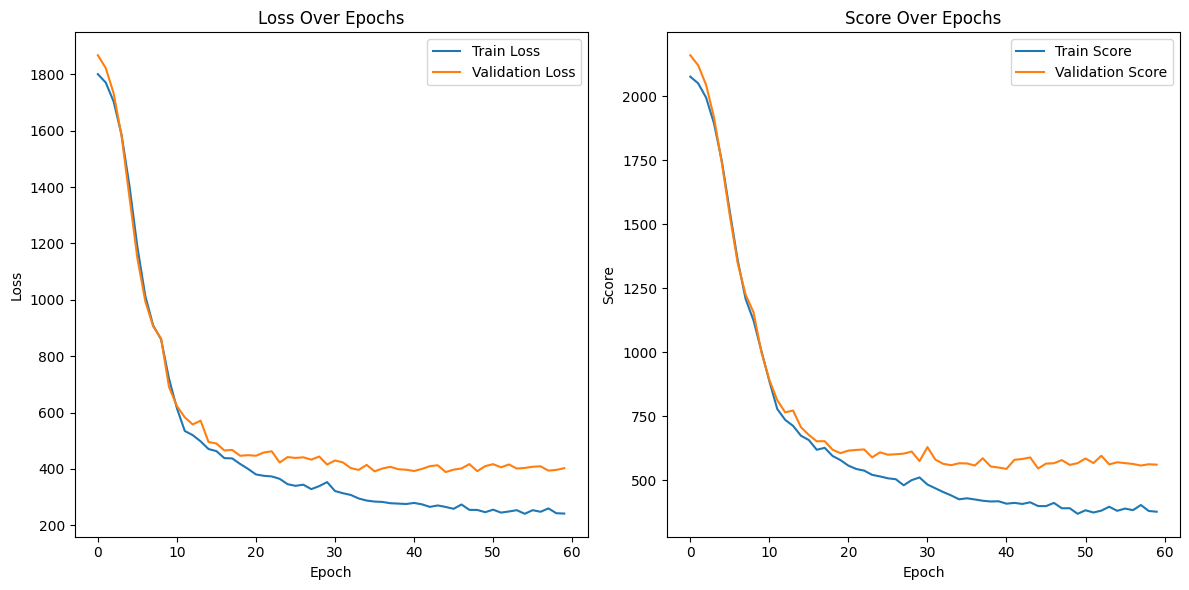

In [75]:
# Create DataFrames
train_loss_df = pd.DataFrame({"epoch": range(len(history_train_loss)), "loss": history_train_loss})
val_loss_df = pd.DataFrame({"epoch": range(len(history_val_loss)), "loss": history_val_loss})

train_score_df = pd.DataFrame({"epoch": range(len(history_train_score)), "score": history_train_score})
val_score_df = pd.DataFrame({"epoch": range(len(history_val_score)), "score": history_val_score})

# Plot loss and score
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Adjusted figure size

# Loss plot
sns.lineplot(data=train_loss_df, x="epoch", y="loss", label="Train Loss", ax=ax[0])
sns.lineplot(data=val_loss_df, x="epoch", y="loss", label="Validation Loss", ax=ax[0])
ax[0].set_title("Loss Over Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Score plot
sns.lineplot(data=train_score_df, x="epoch", y="score", label="Train Score", ax=ax[1])
sns.lineplot(data=val_score_df, x="epoch", y="score", label="Validation Score", ax=ax[1])
ax[1].set_title("Score Over Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Score")
ax[1].legend()

plt.tight_layout()
plt.show()

In [76]:
# Load the best saved model
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()

# Evaluate on test set
test_preds = []
test_targets = []
test_loss = 0

with torch.no_grad():
    for tabular, image, target in test_loader:
        # Move data to device
        tabular = tabular.to(device)
        image = image.to(device)
        target = target.to(device)
        
        output = model(tabular, image)
        
        test_preds.append(output.cpu().numpy())
        test_targets.append(target.unsqueeze(1).cpu().numpy())
        
        loss = criterion(output, target.unsqueeze(1))
        test_loss += loss.item()

# Calculate test metrics
test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

test_rmse = np.sqrt(np.mean((test_preds - test_targets) ** 2))
test_mae = np.mean(np.abs(test_preds - test_targets))

print(f'\nTest Results:')
print(f'Test Loss: {test_loss/len(test_loader):.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')


Test Results:
Test Loss: 339.4531
Test RMSE: 530.4213
Test MAE: 339.9509


<ipython-input-76-7845e3a367d9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))


<ipython-input-77-3d4c87573575>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(tabular).unsqueeze(0).to(device),
<ipython-input-77-3d4c87573575>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image).unsqueeze(0).to(device)


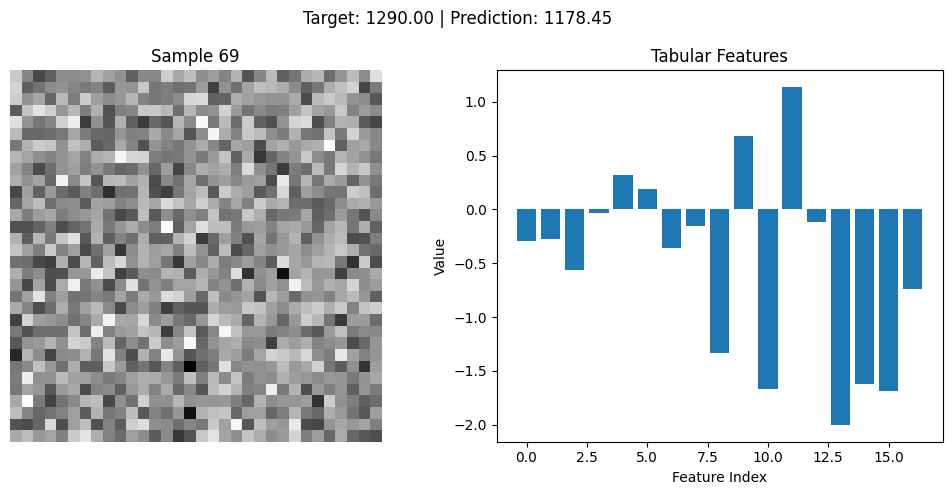

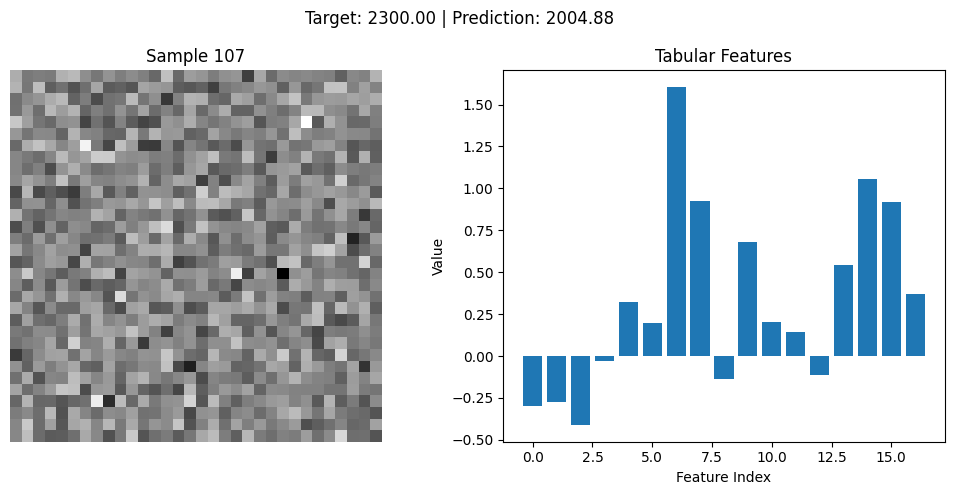

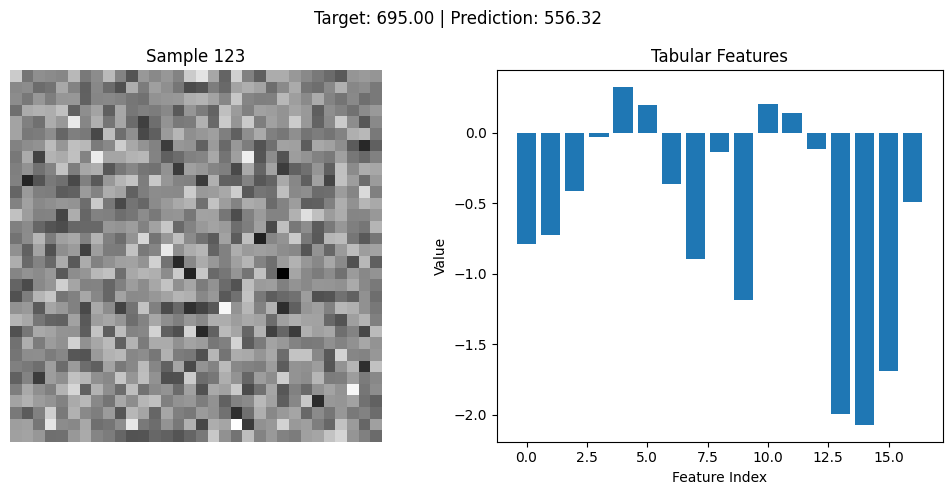

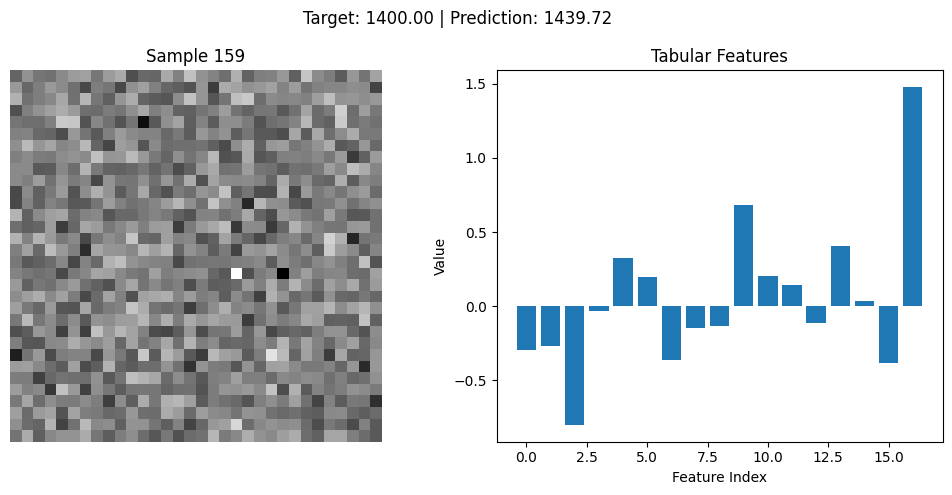

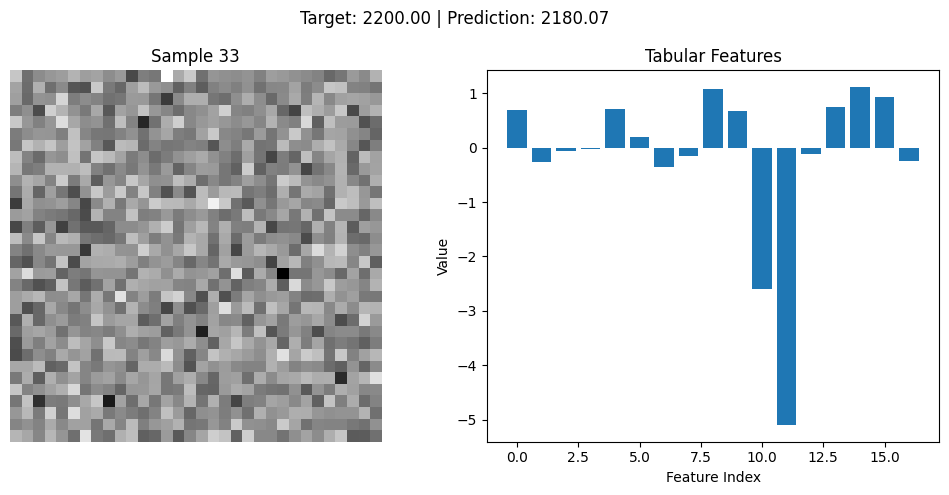

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample(index, tabular_data, image_data, target, prediction):
    plt.figure(figsize=(10, 5))
    
    # Plot image - handle both numpy arrays and torch tensors
    if isinstance(image_data, torch.Tensor):
        image_data = image_data.numpy()
    
    # Try to reshape if it's a perfect square
    img_dim = int(np.sqrt(len(image_data)))
    if img_dim * img_dim == len(image_data):
        image = image_data.reshape(img_dim, img_dim)
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Sample {index}')
        plt.axis('off')
    else:
        # If not a perfect square, plot as a line plot
        plt.subplot(1, 2, 1)
        plt.plot(image_data)
        plt.title('Image Features')
        plt.xlabel('Feature Index')
    
    # Plot tabular data
    plt.subplot(1, 2, 2)
    plt.bar(range(len(tabular_data)), tabular_data)
    plt.title('Tabular Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Value')
    
    # Add prediction and target
    plt.suptitle(f'Target: {target:.2f} | Prediction: {prediction:.2f}')
    plt.tight_layout()
    plt.show()

# Select some random samples to visualize
num_samples_to_show = 5
random_indices = np.random.choice(len(test_dataset), num_samples_to_show, replace=False)

for idx in random_indices:
    tabular, image, target = test_dataset[idx]
    with torch.no_grad():
        pred = model(
            torch.tensor(tabular).unsqueeze(0).to(device),
            torch.tensor(image).unsqueeze(0).to(device)
        ).item()
    
    visualize_sample(
        idx,
        tabular,
        image,
        target,
        pred
    )